# The Hitchhiker's Guide to Parallel Analysis in MDAnalysis

In [23]:
import numpy as np
from joblib import Parallel, delayed
from joblib import parallel_config

import MDAnalysis as mda
from MDAnalysis.tests.datafiles import GRO, XTC

u = mda.Universe(GRO, XTC)

## How does the `Universe` object read information from each timestep using an object-oriented approach?

In [24]:
atoms = u.select_atoms('name CA')
for ts in u.trajectory[:3]:
    print(f'first CA atom position: {atoms.positions[0]}')

first CA atom position: [53.07 44.21 30.75]
first CA atom position: [55.400005 41.56     28.560001]
first CA atom position: [55.990005 40.870003 29.280003]


Access of Atom-level positions

->

View of timestep positions

->

Read from raw files

```python
class AtomGroup:
    @property
    def positions(self):
        return self.universe.trajectory.ts.positions[self.ix]
```


```python
class PDBReader:
    def _read_frame(self, frame):
        self._pdbfile.seek(start)
        chunk = self._pdbfile.read(stop - start).decode()
        tmp_buf = read_position_from_chunk(chunk)

        self.ts.positions = tmp_buf
```

In [25]:
u.trajectory._xdr

```python
class PDBReader:
    def __init__(self, filename):
        ...
        self._pdbfile = util.anyopen(filename, 'rb')
        ...
```

## Why is this related to parallel analysis?

When you run a parallel analysis using the same instance of `Universe` across multiple workers, each worker will attempt to read a different frame, potentially leading to conflicts as they overwrite the state of the `Universe` object.

In [26]:
def read_first_atom_pos(frame):
    u.trajectory[frame]
    return u.atoms[0].position

with parallel_config(backend='threading', n_jobs=4):
   pos_lists = Parallel()(delayed(read_first_atom_pos)(frame) for frame in range(4))

In [27]:
pos_lists

[array([5590.    , 4039.    , 2729.0002], dtype=float32),
 array([5.4560003, 4.057    , 2.9490001], dtype=float32),
 array([559.     , 403.9    , 272.90002], dtype=float32),
 array([559.     , 403.9    , 272.90002], dtype=float32)]

## Multiprocessing-based parallelism and Serilization

We need to implement functions to create new `Universe` objects for each worker or process.

In [28]:
def read_first_atom_pos(frame):
    u.trajectory[frame]
    return u.atoms[0].position
    
# 'locky' is a process-based multiprocessing backend
with parallel_config(backend='loky', n_jobs=4):
   pos_lists = Parallel()(delayed(read_first_atom_pos)(frame) for frame in range(4))

In [29]:
pos_lists

[array([52.02    , 43.560005, 31.550003], dtype=float32),
 array([54.25, 40.98, 29.27], dtype=float32),
 array([54.560005, 40.57    , 29.490002], dtype=float32),
 array([55.9 , 40.39, 27.29], dtype=float32)]

As part of the 2020 GSOC project, we implemented the foundational framework to **serialize**/**pickle** and **deserialize**/**unpickle** the Universe object and all its underlying components.

![](https://www.openrefactory.com/wp-content/uploads/2023/08/pickle-rick-1024x576.jpg)

### File I/O
```python
# in lib/picklable_file_io.py
class FileIOPicklable(io.FileIO):
    def __setstate__(self, state):
        name = state["name_val"]
        self.__init__(name, mode='r')
        try:
            self.seek(state["tell_val"])
        except KeyError:
            pass

    def __reduce_ex__(self, prot):
        ...
        return (self.__class__,
                (self.name, self._mode),
                {"name_val": self.name,
                 "tell_val": self.tell()})
```

### Universe

```python
class Universe:
    @classmethod
    def _unpickle_U(cls, top, traj):
        u = cls(top)
        u.trajectory = traj
        return u

    def __reduce__(self):
        #  Universe's two "legs" of top and traj both serialise themselves.
        return (self._unpickle_U, (self._topology,
                                   self._trajectory))
```

## "Split-apply-combine” parallel analysis

<img src="https://docs.mdanalysis.org/dev/_images/AnalysisBase_parallel.png" alt="drawing" style="width:1000px;"/>

This framework is designed for single-iteration analysis of a trajectory. The approach involves splitting the trajectory into chunks, applying the analysis to each chunk individually, and then combining the results.

## Don’t Panic: A Few Words of Wisdom

1.	I/O operations often become a bottleneck in straightforward analyses.

2. In most cases, per-frame parallelism is not efficient for analyses.

3. No thread parallelism!

4. All objects must be serializable, so ensure they are picklable and not excessively large.

## The Best Approach, IMHO, for Fast Parallel Analysis

In [19]:
from MDAnalysis.analysis.base import AnalysisFromFunction
import matplotlib.pyplot as plt

#import multiprocessing
#multiprocessing.set_start_method('fork')
import dask

In [ ]:
u = mda.Universe('yiip_equilibrium/YiiP_system.pdb',
                 'yiip_equilibrium/YiiP_system_9ns_center.xtc')

In [12]:
# per frame analysis function
def get_water_shell(water_ag):
    return water_ag.n_residues

In [17]:
water_shell = u.select_atoms('resname TIP3 and around 5 protein', updating=True)
ana = AnalysisFromFunction(get_water_shell,
                            trajectory=u.trajectory,
                            water_ag=water_shell)

#ana.run(backend='multiprocessing')
ana.run(backend='dask', n_workers=6)

In [14]:
ana.results

{'timeseries': array([2412, 2423, 2420, 2407, 2433, 2416, 2393, 2416, 2392, 2422, 2377,
       2425, 2418, 2413, 2400, 2432, 2377, 2325, 2352, 2361, 2398, 2390,
       2375, 2391, 2396, 2395, 2372, 2379, 2429, 2404, 2408, 2420, 2378,
       2393, 2349, 2355, 2384, 2372, 2393, 2393, 2401, 2373, 2419, 2395,
       2380, 2396, 2387, 2367, 2340, 2336, 2297, 2335, 2316, 2333, 2310,
       2328, 2313, 2344, 2295, 2353, 2343, 2355, 2329, 2331, 2386, 2382,
       2387, 2346, 2353, 2370, 2338, 2345, 2340, 2346, 2346, 2377, 2363,
       2372, 2352, 2355, 2325, 2352, 2354, 2352, 2376, 2388, 2344, 2347,
       2383, 2377, 2417, 2382, 2370, 2369, 2385, 2394, 2370, 2383, 2406,
       2436, 2415, 2371, 2392, 2383, 2338, 2369, 2366, 2401, 2386, 2385,
       2353, 2378, 2327, 2386, 2391, 2340, 2363, 2384, 2359, 2384, 2394,
       2401, 2376, 2368, 2364, 2379, 2388, 2404, 2403, 2406, 2408, 2376,
       2429, 2408, 2406, 2368, 2375, 2386, 2381, 2398, 2445, 2359, 2396,
       2381, 2387, 2405, 2410, 2396,

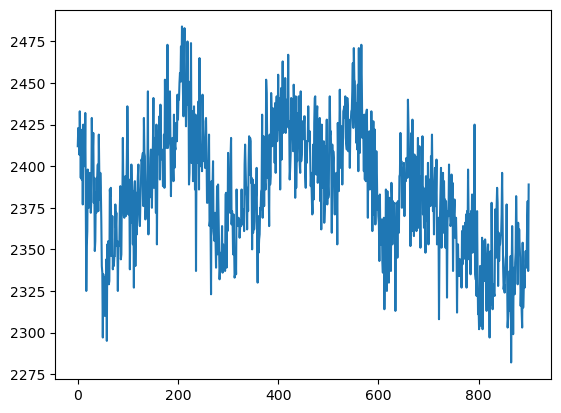

In [ ]:
plt.plot(ana.results.frames, ana.results.timeseries)

In [16]:
water_shell = u.select_atoms('resname TIP3 and around 5 protein', updating=True)
ana = AnalysisFromFunction(get_water_shell,
                            trajectory=u.trajectory,
                            water_ag=water_shell)

#ana.run(backend='multiprocessing')
ana.run(backend='serial')

In [22]:
133 / 26

5.115384615384615